In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from fourier_2d import FNO2d
from fourier import FNO1d
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from normal import UnitGaussianNormalizer
from matplotlib import cm
import scipy.io
from utilities3 import LpLoss

(5000, 50, 1)


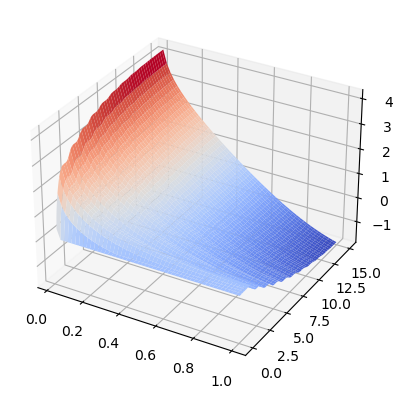

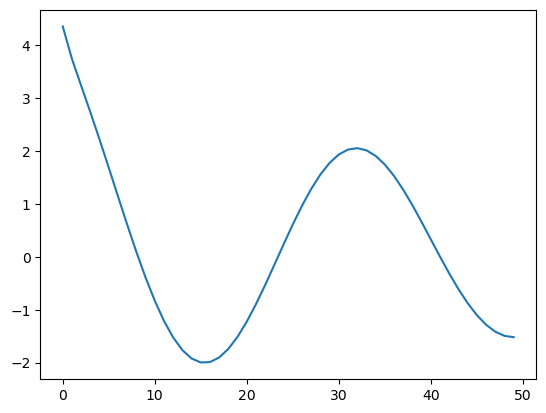

In [2]:
# Load Data

L = 1
T = 14.95
dt = 0.05
dx = 0.02
nt = int(round(T/dt))
nx = int(round(L/dx))
npoints = 1000
sampleRate = 29*2

t1 = np.linspace(0.05, T, nt)
x1 = np.linspace(0.02, L, nx)

x = scipy.io.loadmat("thetaHat.mat")["tHatData"]
x = x.reshape(npoints, nt,nx).astype(np.float32)
y = scipy.io.loadmat("gain.mat")["gainData"]
y = y.reshape(npoints, nt, nx).astype(np.float32)
    
xArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
yArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
x1, t1 = np.meshgrid(x1, t1)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, x[0, :, :], cmap=cm.coolwarm)

for i in range(npoints):
    for j in range(int(nt/sampleRate)):
        for k in range(nx):
            xArr[i*int(nt/sampleRate)+j] = x[i, int(j*sampleRate), :]
            yArr[i*int(nt/sampleRate)+j] = y[i, int(j*sampleRate), :]
x=xArr.reshape((npoints*int(nt/sampleRate), nx, 1))
y=yArr.reshape((npoints*int(nt/sampleRate), nx, 1))

plt.figure()
plt.plot(xArr[28])
print(x.shape)
#plt.figure()
#plt.plot(y[0])

In [3]:
# Parameters
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 50
gamma = 0.5
learning_rate = 0.001
step_size= 100
modes = 12
width = 32

In [4]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()


trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [5]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [9]:
model = FNO1d(modes, width, 1, 1).cuda()
print(count_params(model))

106977


In [10]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [11]:
t = default_timer()
loss = LpLoss()
train_mseArr = []
test_mseArr = []
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)

        mse = loss(out, y)
        mse.backward()
        
        optimizer.step()
        train_mse += mse.item()
        
    scheduler.step()
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x)
            test_mse += loss(out, y).item()
            
    train_mse /= len(trainData)
    test_mse /= len(testData)
    
    train_mseArr.append(train_mse)
    test_mseArr.append(test_mse)
    
    t2 = default_timer()
    if ep%50 == 0:
        print(ep, t2-t1, train_mse, test_mse)
print(default_timer()-t)

0 0.6432246319018304 0.47437930670049455 0.1888526752591133
50 0.4171468080021441 0.022557364590466023 0.02157307956367731
100 0.4162703868933022 0.010128792991033858 0.00829076417721808
150 0.41446886491030455 0.008062447441948785 0.008667872287333012
200 0.3799096569418907 0.005341035357883407 0.004104582616128028
250 0.36116723995655775 0.007947972634186347 0.005775980278849601
300 0.416514849755913 0.0037717933792413938 0.0030581391416490077
350 0.41601182194426656 0.003730755625292659 0.003242520825006068
400 0.41748556308448315 0.0025902076081062357 0.0027012333273887636
450 0.41525100683793426 0.002886638366099861 0.002898437739349902
500 0.4171842341311276 0.0024284570374422604 0.0024062558310106396
550 0.4220830393023789 0.002389159458430691 0.002177688875235617
600 0.41921701468527317 0.0021126334451966816 0.0020655076252296565
650 0.42054600501433015 0.002077912402132319 0.0021046536276116967
700 0.42301655234768987 0.0019975154544226827 0.0019438858376815914
750 0.424074443

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


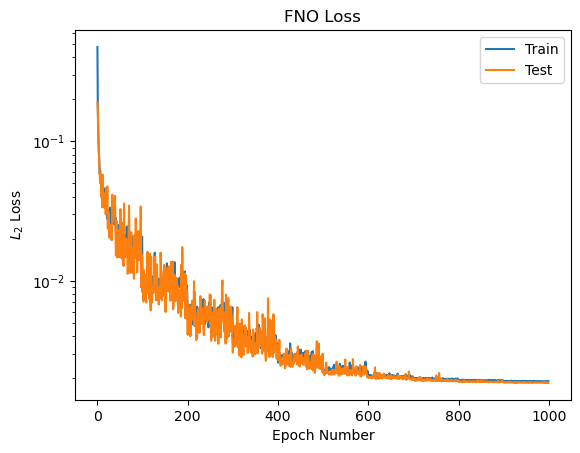

In [12]:
plt.title("FNO Loss")
plt.plot(train_mseArr, label="Train")
plt.plot(test_mseArr, label="Test")
plt.yscale("log")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.legend()
plt.savefig('fno.eps')

/tmp/ipykernel_2406905/746845414.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


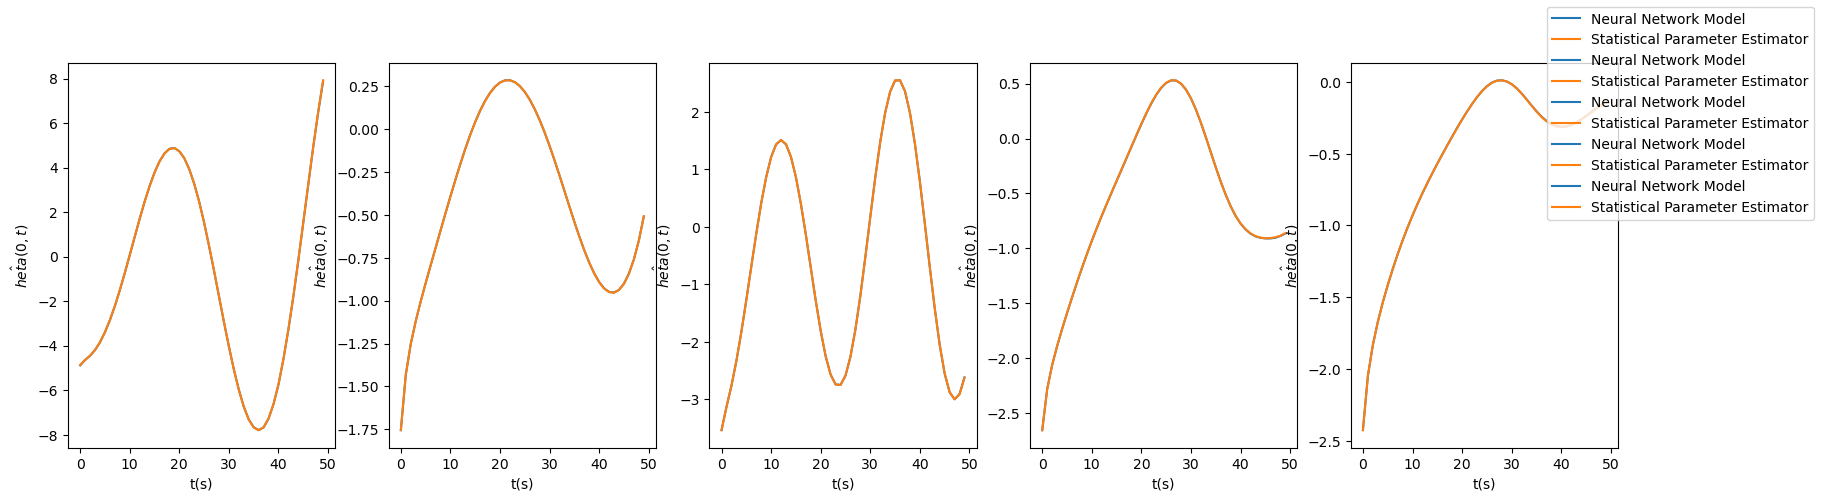

In [13]:
# Show some examples at the boundry
index = 0
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()   
        out = model(x)
        l1 = ax[index].plot(out[0,:].detach().cpu(), label="Neural Network Model")
        l2 = ax[index].plot(y[0, :].detach().cpu(), label="Statistical Parameter Estimator")
        ax[index].set_xlabel("t(s)")
        ax[index].set_ylabel("$\hat{\theta}(0, t)$")
        index+=1
        if index > 4:
            break
fig.legend()
fig.show()

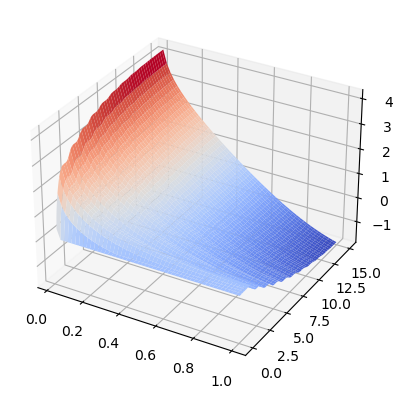

In [14]:
# Load Data

L = 1
T = 14.95
dt = 0.05
dx = 0.02
nt = int(round(T/dt))
nx = int(round(L/dx))
npoints = 1000
sampleRate = 29*2

t1 = np.linspace(0.05, T, nt)
x1 = np.linspace(0.02, L, nx)

x = scipy.io.loadmat("thetaHat.mat")["tHatData"]
x = x.reshape(npoints, nt,nx).astype(np.float32)
y = scipy.io.loadmat("gain.mat")["gainData"]
y = y.reshape(npoints, nt, nx).astype(np.float32)
    
xArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
yArr = np.zeros((npoints*int(nt/sampleRate), nx), dtype=np.float32)
x1, t1 = np.meshgrid(x1, t1)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, x[0, :, :], cmap=cm.coolwarm)


In [15]:
# Parameters
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 100
modes = 12
width = 64

In [16]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()


trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [17]:
with torch.no_grad():
    test_mse = 0
    mse_end = 0
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
        outTensor = torch.from_numpy(np.zeros((batch_size, x.shape[1], x.shape[2]), dtype=np.float32)).cuda()
        for timeStep in range(x.shape[1]):
            out = model(x[:, timeStep, :].reshape(batch_size, x.shape[2], 1))
            outTensor[:, timeStep, :] = out.reshape(batch_size, x.shape[2])

        test_mse += loss(outTensor, y).item()
print("TEST MSE For " + str(batch_size) + " Instances:", test_mse/len(testData))

TEST MSE For 20 Instances: 0.003591278521344066


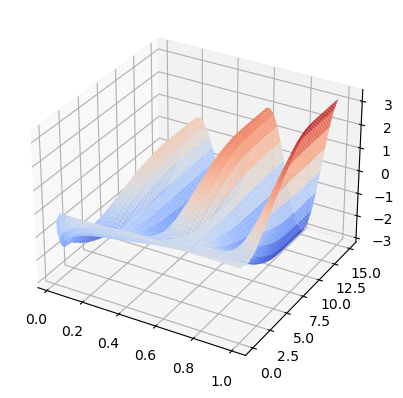

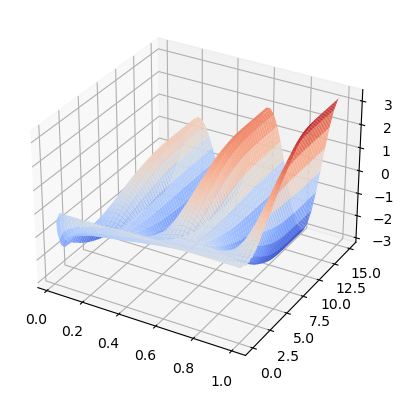

In [18]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, outTensor[2, :, :].detach().cpu().numpy(), cmap=cm.coolwarm)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, y[2, :, :].detach().cpu().numpy(), cmap=cm.coolwarm)

In [20]:
torch.save(model.state_dict(), 'fnoModel2')